In [1]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

# import warnings
# warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
reload(cgi)

import misc_funs as misc

iwa = 6
owa = 20

data_dir = cgi.data_dir

# dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
# dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [3]:
poppy.conf.use_cupy = True
poppy.conf.use_mkl = True
poppy.conf.use_fftw = True

# Test monochromatic PSFs.

Propagating wavelength 825.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.847s


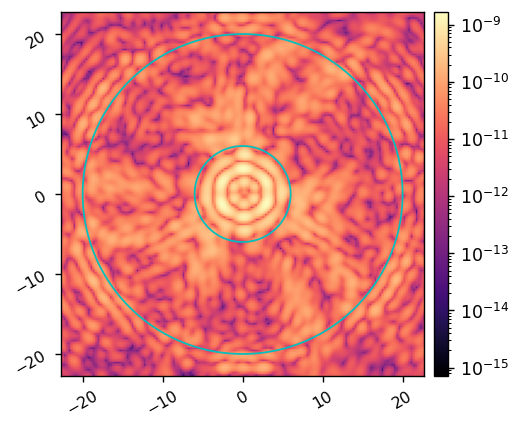

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-wide_psf_gpu.fits


In [4]:
reload(cgi)
mode = cgi.CGI(cgi_mode='spc-wide', 
               npsf=150,
               use_pupil_defocus=True, use_opds=False)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-wide_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-wide_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [15]:
%%timeit
wf = hlc.calc_psf(quiet=True)

299 ms ± 778 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Propagating wavelength 825.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.933s


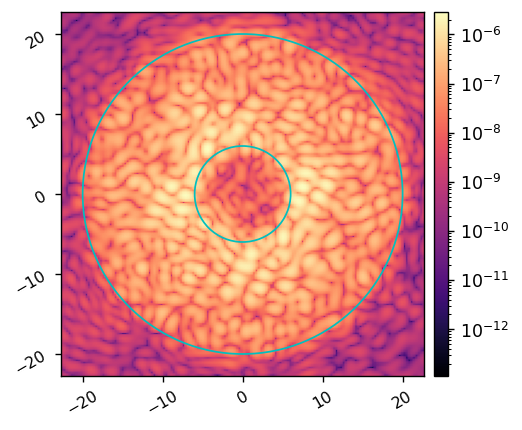

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-wide_opds_psf_gpu.fits


In [8]:
mode = cgi.CGI(cgi_mode='spc-wide', 
               npsf=150,
               use_pupil_defocus=True, use_opds=True)

# mode.set_dm1(dm1_flat)
# mode.set_dm2(dm2_flat)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-wide_opds_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-wide_opds_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [22]:
%%timeit
wf = mode_opds.calc_psf(quiet=True)

349 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs with GPU parallelization.

### Create the actors to calculate each individual PSF/image with ray.remote() actors.

num_gpus can be set to whatever fractional GPU the user desires

In [10]:
CGI = ray.remote(cgi.CGI) # make a ray actor class from the original CGI class

wavelength_c = 825e-9*u.m

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

kwargs = {'cgi_mode':'spc-wide',
          'npsf':150,
          'use_pupil_defocus':True,
          'use_opds':False}
actors = []
for i in range(nlam):
    actors.append(CGI.remote(wavelength=wavelengths[i], **kwargs))

### Calculate each image by calling the remote function of each actor. 

In [16]:
time

<module 'time' (built-in)>

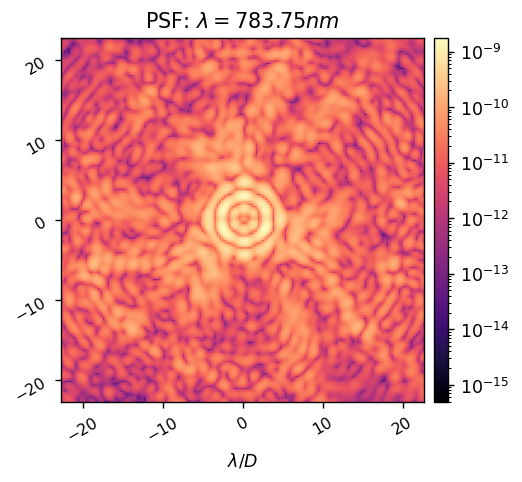

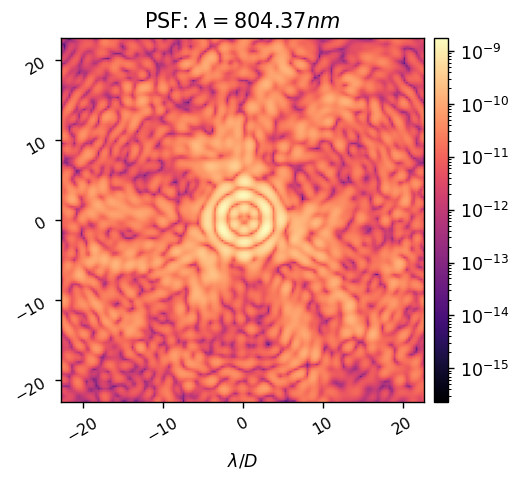

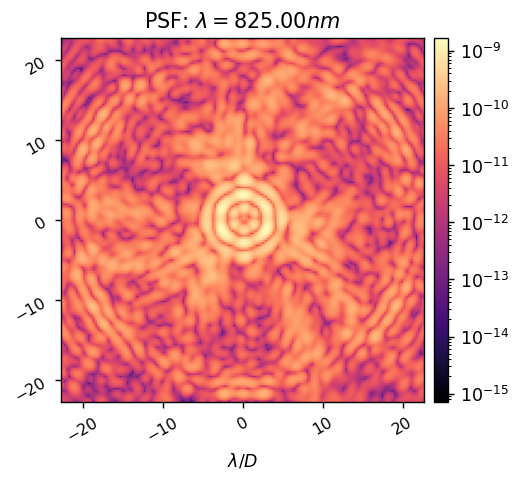

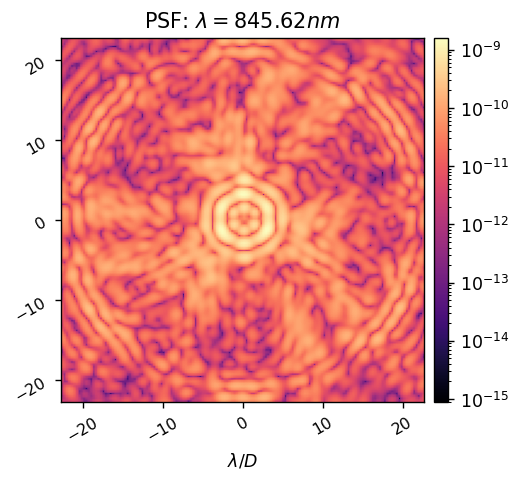

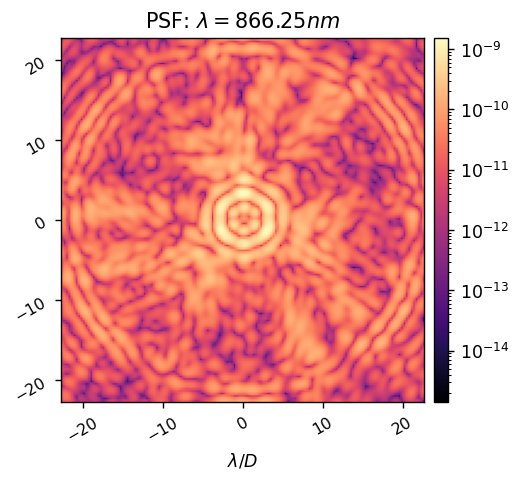

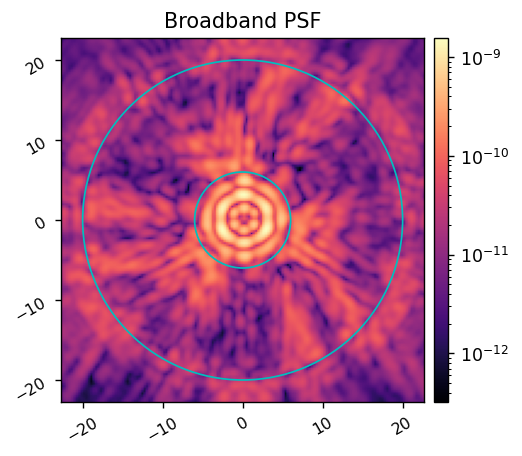

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-wide_psf_broad_gpu.fits


In [11]:
pending_ims = []
for i in range(len(actors)):
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = ray.get(pending_ims)
clear_output()

for i in range(nlam):
    misc.imshow1(ims[i], 
                 'PSF: $\lambda={:.2f}$'.format(wavelengths[i].to(u.nm)), 
                 pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$',
                 lognorm=True)
    
psf_broad = np.sum(ims, axis=0)/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_broad, 'Broadband PSF', lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-wide_psf_broad_gpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-wide_psf_broad_cpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})